In [2]:
# must insert this statement to render the plots within the notebook
# this is specific to the ipython notebook
%matplotlib inline

## Import statements
# netcdf/numpy/xray/stats
import numpy as np
from datetime import datetime, timedelta
import pandas as pd
import xarray as xray
from scipy.stats.stats import pearsonr

# OS interaction
import sys, pickle, os

# import subplots function for plotting
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context('talk')
import kgraph
import matplotlib
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.basemap import Basemap

# Solargeometry
import solargeo

#### Directory Lists
# Unix
if 'linux' in sys.platform:
    dir_pre = '/home/lapok/gdrive/'
# Mac
elif 'darwin' in sys.platform:
    dir_pre = '/Users/karllapo/gdrive/'

dirProj = dir_pre+'SnowHydrology/proj/TurbulenceFeedbacks/'           # Project directory
dirPrint = dir_pre+'SnowHydrology/proj/TurbulenceFeedbacks/Graphics'  # Directory for printing figures
dirData = dir_pre+'SnowHydrology/proj/TurbulenceFeedbacks/data/SCP'  # Processed data directory

/Users/karllapo/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


## Define Functions

In [3]:
def bulkRichardson(# input
                   airTemp,                  # air temperature (K)
                   sfcTemp,                  # surface temperature (K)
                   windspd,                  # wind speed (m s-1)
                   mHeight,                  # measurement height (m)
                   computeDerivative=False,  # flag to compute the derivative
                     ):
# -------------------------------------------------------------------------------------------------------
    ########
    # Local variables
    gravity = 9.81
    T_grad = airTemp - sfcTemp
    T_mean = 0.5*(airTemp + sfcTemp)
    RiMult = (gravity*mHeight)/(windspd*windspd)
    # compute the Richardson number
    RiBulk = (T_grad/T_mean) * RiMult
    
    ########
    # compute the derivative in the Richardson number
    if computeDerivative:
        dRiBulk_dAirTemp =  RiMult/T_mean - RiMult*T_grad/(0.5*((airTemp + sfcTemp)**2.))
        dRiBulk_dSfcTemp = -RiMult/T_mean - RiMult*T_grad/(0.5*((airTemp + sfcTemp)**2.))
    else:
        dRiBulk_dAirTemp = 1.
        dRiBulk_dSfcTemp = 1.

    return (RiBulk,             # bulk Richardson number (-)
            dRiBulk_dAirTemp,   # derivative in the bulk Richardson number w.r.t. air temperature (K-1)
            dRiBulk_dSfcTemp)   # derivative in the bulk Richardson number w.r.t. surface temperature (K-1)

In [4]:
def gradRichardson(# input
                    airTemp,                # air temperature (K) corresponding to heights N
                    windSpd,                # wind speeds (m s^-1) corresponding to heights N
                    mHeight                 # measurement heights (m) of wind and air temperature
                    ):
# -------------------------------------------------------------------------------------------------------
    #########
    # Sub-function
    def logGrad(x1,x2,z1,z2):
        # Log gradient function
        mid = np.exp((np.log(z1) + np.log(z2))/2)
        grad = 1/mid * ((x2 - x1)/(np.log(z2)-np.log(z1)))
        return grad,mid
# -------------------------------------------------------------------------------------------------------

    #########
    # Constants/Parameters
    g = 9.81                                # gravitational acceleration (m s^-2)
    numL = mHeight.size                     # Number of layers
    
    #########
    # Difference each heigh using logGrad
    gradWind = np.zeros(numL-1)             # Gradient in wind
    zMid = np.zeros(numL-1)                 # Log-averaged height beetween layers
    gradTheta = np.zeros(numL-1)            # Gradient in virtual temperature
    thetaMid = np.zeros(numL-1)             # "virtual" temperature at the mid-point between levels
    
    for k in np.arange(0,numL-1):
        (grad_u[k],zm[k]) = logGrad(u[k],u[k+1],z[k],z[k+1])
        (grad_theta[k],zm[k]) = logGrad(theta[k],theta[k+1],z[k],z[k+1])
        theta_m[k] = np.exp((np.log(theta[k]) + np.log(theta[k+1]))/2)

    ## Calculate the gradient Richardson Number
    gradRi = g/theta_m * (grad_theta/grad_u**2)
    gradRiMean = np.mean(gradRi)
    return(gradRi,gradRiMean)

## Notes
Calculating z0 and the Obukhov length using the gradient Ri number

###### Gradients
Calculate the gradients in $u$ and $\theta$ between each layer using the expression:

$\frac{\Delta u}{\Delta z} = \frac{1}{z_m} \frac{u_{z2} - u_{z1}}{ln(z2)-ln(z1)} $

where $z_m$ is the average of the log heights $\frac{ln(z1) + ln(z2)}{2}$ and $u$ can be exchanged with $\theta$

###### gradient Richardson Number
$Ri = \frac{-d\theta}{dz} \frac{du}{dz}^{-2} $

$ b = g\theta_m/\theta $

#### Friction Velocity
First finding the friction velocity, ($u_*$)

Given that $\Phi_h = \Phi_M^2 = 1-16 \frac{z}{L} $ (e.g., $\gamma_1 = 16$)

Equation 6.2 from the notes
$kz/u_{*} \frac{du}{dz} = \Phi_m(\frac{z}{L})$

Solve for $u_{*}$:

$kz/\Phi_m(\frac{z}{L}) \frac{du}{dz} = u_{*}$

#### Surface Roughness
Finding the surface roughness using equation 6.14 from the class notes.

$u(z) = \frac{u_*}{k} (\ln( \frac{z}{z_0}) - \Psi_m(\frac{z}{L})) $ (eq. 6.14)

where $\Psi_m = log(\frac{1+x^2}{2}\frac{1+x}{2}^2) - 2 \tan^-1(x) + \pi/2$

and $x = (1-\gamma_1 \frac{z}{L})^{1/4}$

solving for $z_0$

$z_0 = z/ \exp(\frac{k u(z)}{u_*} + \Psi_m)$ 

In [5]:
##################################
## Save observations to netcdfs ##
##################################
os.chdir(dirData)
Atower = xray.open_dataset('SCP.Atower.netcdf')
Ctower = xray.open_dataset('SCP.Ctower.netcdf')
Mtower = xray.open_dataset('SCP.Mtower.netcdf')
soilObs = xray.open_dataset('SCP.soil_obs.netcdf')
radObs = xray.open_dataset('SCP.rad_obs.netcdf')
fluxObs = xray.open_dataset('SCP.flux_obs.netcdf')

In [6]:
###############
## Aggregate ##
###############

## 30 minute averages of fluxes
fluxObs_30m = fluxObs.resample(freq='30Min',how='mean',dim='time')
radObs_30m = radObs.resample(freq='30Min',how='mean',dim='time')
soilObs_30m = soilObs.resample(freq='30Min',how='mean',dim='time')

## Mean ground heat flux @ both sites
soilObs_30m['Gsfc'] = xray.concat([soilObs_30m.Gsfc_c,\
                                    soilObs_30m.Gsfc_g],dim='site').mean(dim='site')
soilObs_30m['Gsoil_5cm'] = xray.concat([soilObs_30m.Gsoil_5cm_c,\
                                    soilObs_30m.Gsoil_5cm_g],dim='site').mean(dim='site')

## Boundary Layer Obs Analysis

In [7]:
########
# Surface temperature from upwelling longwave
sigma = 5.67*10**-8.                   # Stefan-Boltzmann constant
Tsfc = (radObs.Rlw_out/sigma)**(1./4.)

# Insert into Mtower xarray.Dataset
Mtower['Tsfc'] = (('time'), Tsfc-273.15)

########
# Bulk Richardson Number
Mtower['UBar_15m'] = (('time'), (Mtower.U_15m_M**2+Mtower.V_15m_M**2)**(1./2.))
Mtower.UBar_15m[Mtower.UBar_15m > 10] = np.nan
Mtower['UBar_2m'] = (('time'), (Mtower.u_2m_M**2+Mtower.v_2m_M**2)**(1./2.))
Mtower.UBar_15m[Mtower.UBar_2m > 10] = np.nan
RiBulk,_,_ = bulkRichardson(Mtower.T_1m_M+273.15,Mtower.Tsfc+273.15,Mtower.UBar_2m,15.)
Mtower['RiBulk'] = RiBulk


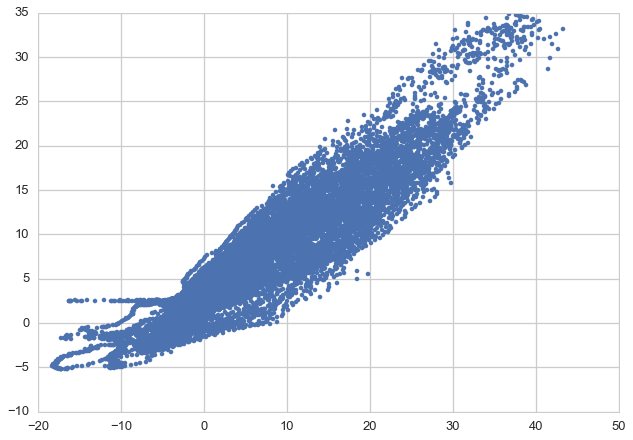

In [8]:
plt.plot(Mtower.Tsfc,soilObs.Tsoil_0_6cm_c,'.')

In [9]:
# ########
# # Gradient Richardson Number
# nTempFields = ['T_1m_M', 'T_2_5m_M', 'T_4m_M', 'T_6m_M', 'T_8m_M', 'T_15m_M']
# Mtower.
# nWindFields = ['']
# heights = [1.,2.5,4.,6.,8.,15.]
# for t in Mtower.time:
#     nTemp = [Mtower[ntf].sel(time=t).values for ntf in nTempFields]
#     _,RiGrad = gradRichardson(,Mtower.Tsfc+273.15,Mtower.UBar_15m,15.)

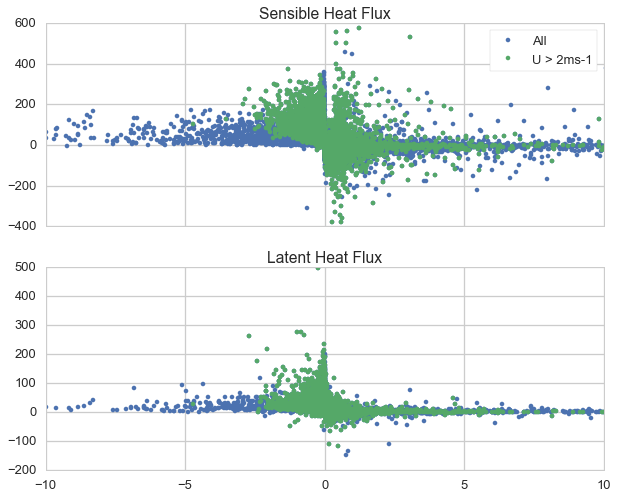

In [10]:
Rmin = -10
Rmax = 10
fig,axes = plt.subplots(2,1,figsize=(10,8),sharex=True)

# Index of high wind speeds (Ubar > 2ms-1)
uInd = np.nonzero( (Mtower.UBar_15m > 2.).values)

# Sensible heat flux
ax = axes[0]
ax.plot(RiBulk,fluxObs.w_tc__10m_M,'.',label='All')
ax.plot(RiBulk[uInd],fluxObs.w_tc__10m_M[uInd],'.',label='U > 2ms-1')
ax.set_xlim(Rmin,Rmax)
ax.legend(frameon=True)
ax.set_title('Sensible Heat Flux')

ax = axes[1]
ax.plot(RiBulk,fluxObs.w_h2o__10m_M,'.',label='All')
ax.plot(RiBulk[uInd],fluxObs.w_h2o__10m_M[uInd],'.',label='U > 2ms-1')
ax.set_xlim(Rmin,Rmax)
ax.set_title('Latent Heat Flux')

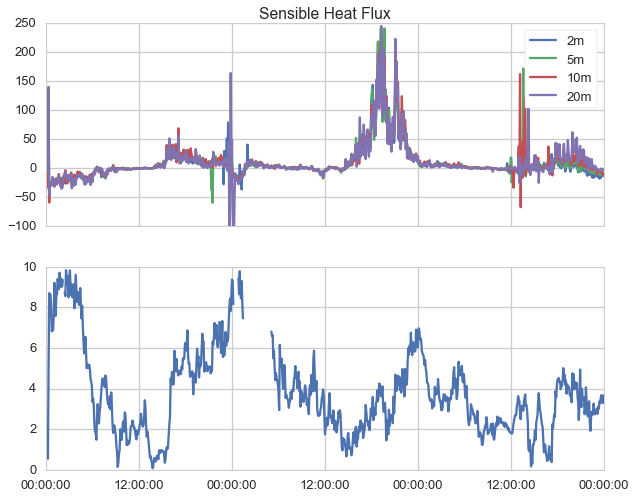

In [11]:
d1 = datetime(2012,10,24)
d2 = datetime(2012,10,27)
Rmin = -10
Rmax = 10
fig,axes = plt.subplots(2,1,figsize=(10,8),sharex=True)

# Index of high wind speeds (Ubar > 2ms-1)
uInd = np.nonzero( (Mtower.UBar_15m > 2.).values)

# Sensible heat flux
ax = axes[0]
ax.plot(Mtower.time,fluxObs.w_tc__2m_M,label='2m')
ax.plot(Mtower.time,fluxObs.w_tc__5m_M,label='5m')
ax.plot(Mtower.time,fluxObs.w_tc__10m_M,label='10m')
ax.plot(Mtower.time,fluxObs.w_tc__20m_M,label='20m')
ax.set_ylim(-100,250)
ax.set_xlim(d1,d2)
ax.legend(frameon=True)
ax.set_title('Sensible Heat Flux')

ax = axes[1]
Mtower.UBar_15m[Mtower.UBar_15m > 10] = np.nan
ax.plot(Mtower.time,Mtower.UBar_15m)

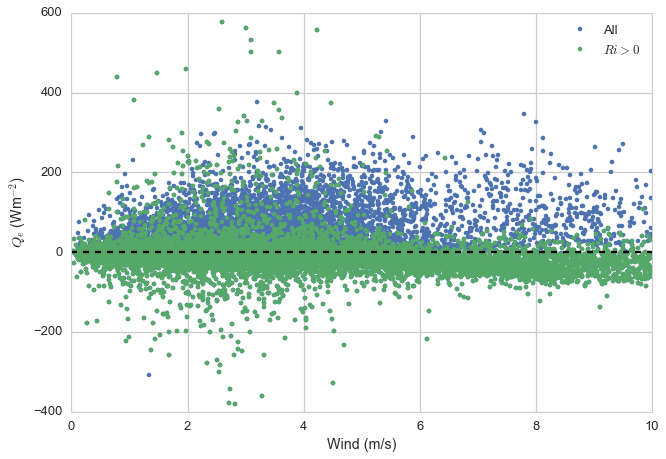

In [12]:
plt.plot(Mtower.UBar_15m,fluxObs.w_tc__10m_M,'.',label='All')
plt.plot(Mtower.UBar_15m.where(Mtower.RiBulk > 0),fluxObs.w_tc__10m_M.where(Mtower.RiBulk > 0),\
         '.',label='$Ri > 0$')
plt.plot([0, 10],[0,0],'k--')
ax = plt.gca()
ax.set_xlabel('Wind (m/s)')
ax.set_ylabel('$Q_e$ (Wm$^{-2}$)')
ax.legend()

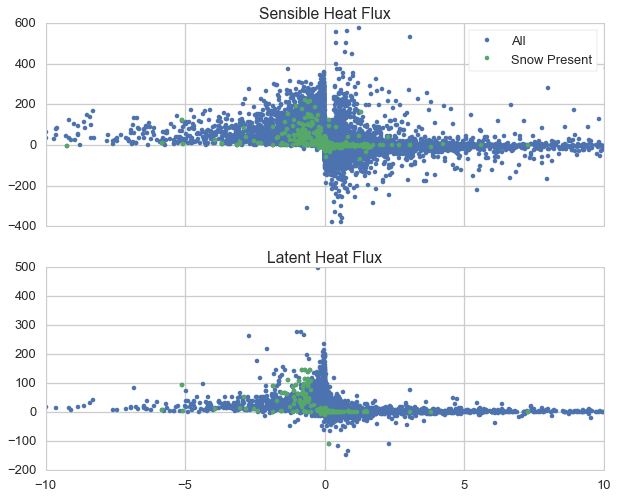

In [13]:
d1 = datetime(2012,10,24)
d2 = datetime(2012,10,27)

Rmin = -10
Rmax = 10

fig,axes = plt.subplots(2,1,figsize=(10,8),sharex=True)

# Sensible heat flux
ax = axes[0]
ax.plot(Mtower.RiBulk,fluxObs.w_tc__10m_M,'.',label='All')
ax.plot(Mtower.RiBulk.sel(time=slice(d1,d2)),fluxObs.w_tc__10m_M.sel(time=slice(d1,d2)),\
        '.',label='Snow Present')
ax.set_xlim(Rmin,Rmax)
ax.legend(frameon=True)
ax.set_title('Sensible Heat Flux')

ax = axes[1]
ax.plot(Mtower.RiBulk,fluxObs.w_h2o__10m_M,'.',label='All')
ax.plot(Mtower.RiBulk.sel(time=slice(d1,d2)),fluxObs.w_h2o__10m_M.sel(time=slice(d1,d2)),\
        '.',label='U > 2ms-1')
ax.set_xlim(Rmin,Rmax)
ax.set_title('Latent Heat Flux')

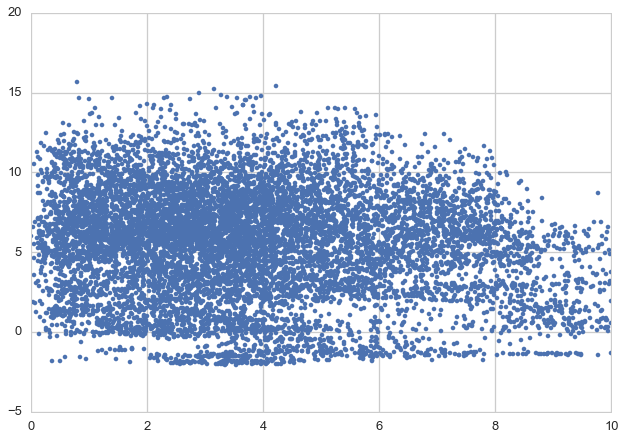

In [14]:
plt.plot(Mtower.UBar_15m.where(radObs.Rsw_in <= 10),\
         Mtower.T_15m_M.where(radObs.Rsw_in <= 10)-Mtower.Tsfc.where(radObs.Rsw_in <= 10),'.')

### From AMS BL conference
- presenter (session 2a on Monday) shows an S-shape relationship between wind speed and delta-T at 10m. I don't have anything anywhere close to resembling that @ SNQ.

(-10, 30)

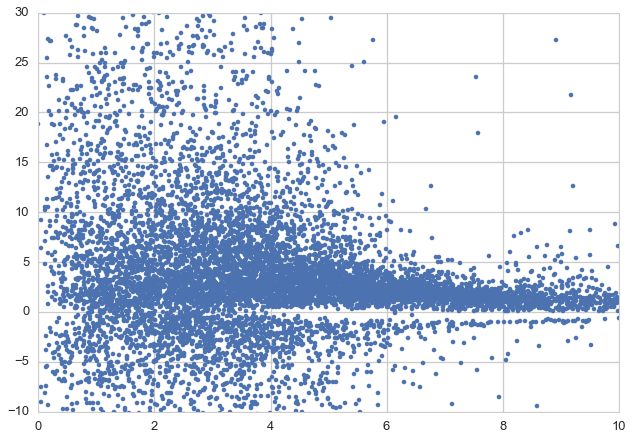

In [15]:
plt.plot(Mtower.UBar_15m.where(radObs.Rsw_in <= 10),\
         (radObs.Rlw_in-radObs.Rlw_out).where(radObs.Rsw_in <= 10)/fluxObs.w_tc__5m_M.where(radObs.Rsw_in <= 10),'.')
plt.gca().set_ylim(-10,30)

### Regimes of SBL
- left of ~6m/s has a turbulent boundary layer
- right of ~6m/s has a radiatively cooling boundary layer
- negative values are weird
- robust at several different heights that I tested arbitrarily

(-5, 15)

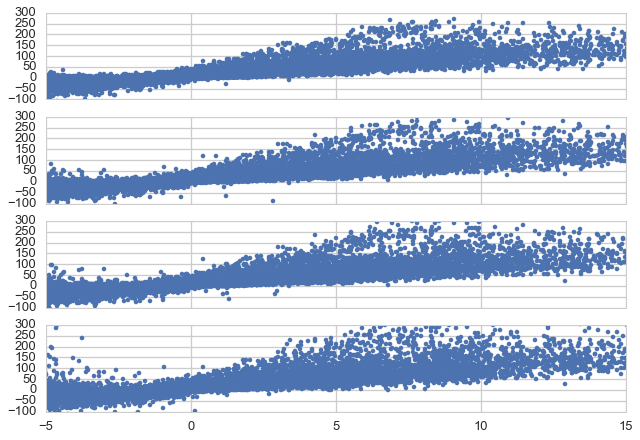

In [46]:
fig, axes = plt.subplots(4,1,sharex=True)

ax = axes[0]
ax.plot(Mtower.Tsfc-Mtower.T_15m_M,fluxObs.w_tc__2m_M,'.')
ax.set_ylim(-100,300)
ax.set_xlim(-5,15)

ax = axes[1]
ax.plot(Mtower.Tsfc-Mtower.T_15m_M,fluxObs.w_tc__4m_M,'.')
ax.set_ylim(-100,300)
ax.set_xlim(-5,15)

ax = axes[2]
ax.plot(Mtower.Tsfc-Mtower.T_15m_M,fluxObs.w_tc__5m_M,'.')
ax.set_ylim(-100,300)
ax.set_xlim(-5,15)

ax = axes[3]
ax.plot(Mtower.Tsfc-Mtower.T_15m_M,fluxObs.w_tc__10m_M,'.')
ax.set_ylim(-100,300)
ax.set_xlim(-5,15)


# Offline Turbulence

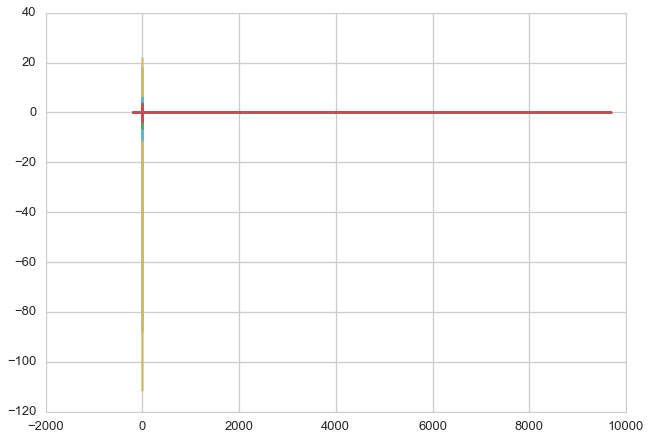

In [47]:
volHeatCapacityAir = iden_air*Cp_air           # volumetric heat capacity of air (J m-3)

Cobs = fluxObs.w_tc__1m/(-volHeatCapacityAir*(Mtower.Tsfc-Mtower.T_1m_M))

plt.plot(Mtower.RiBulk,Cobs)

In [22]:
## Met variables
mHeight = 1.
scalarGroundSnowFraction  = 0.
# "soil"RelHumidity 
# scalarSoilRelHumidity  = scalarGroundSnowFraction*1._dp + (1._dp - scalarGroundSnowFraction)*soilRelHumidity_noSnow

## Turbulence parameters
critRichNumber = .2
Louis79_bparam = 9.4
Mahrt87_eScale = 1.
z0Ground = .005
machineEpsilon = (np.finfo(float).eps)

## Misc. variables
ixStability = ('standard','louisInversePower','mahrtExponential')
ixDerivMethod = 'none'

In [23]:
ind = np.nonzero( (Mtower.RiBulk > 0.).values )
# Lots of values, lets only use 5%
l = ind[0].size
ind = ind[0][0:int(np.round(l/20.))]
ind = np.arange(0,Mtower.time.size)
sensible = xray.Dataset()
sensible.coords['time'] = Mtower.time[ind]
latent = xray.Dataset()
latent.coords['time'] = Mtower.time[ind]

for stab in ixStability:
    senHeatGround = np.ones(Mtower.time[ind].size)*-9999       # sensible heat flux from ground surface (W m-2)
    latHeatGround = np.ones(Mtower.time[ind].size)*-9999       # latent heat flux from ground surface (W m-2)
    
    # Loop over each time step with snow
    for n,d in enumerate(Mtower.time[ind]):
        # Met data at Snoqualmie on the given date
        ds = Mtower.sel(time=d)
        snowDepth = 0.                 # (m)
        airpres = 100000               # (Pa)
        svp,_ = satVapPress(ds.T_1m_M) # Saturation vapor pressure
        VPair = svp*ds.RH_1m_M/100.    # Vapor pressure (Pa)
        groundTemp = ds.Tsfc+273.15    # (C) -> (K)
        airtemp = ds.T_1m_M+273.15     # (C) -> (K)
        windspd = ds.UBar_2m           # (m/s)
        soilRelHumidity = soilObs.Qsoil_c.sel(time=d)/100. # (fraction)
        
        ## SUMMA Turbulence routine
        x1,x2,senHeatGround[n],latHeatGround[n],x3,x4 = \
                     turbFluxes(ixDerivMethod,stab,airtemp,airpres,\
                                VPair,windspd,groundTemp,soilRelHumidity,mHeight,snowDepth)
    
    senHeatGround[senHeatGround == -9999] = np.nan
    latHeatGround[latHeatGround == -9999] = np.nan
    sensible[stab] = (('time'),senHeatGround)
    latent[stab] = (('time'),latHeatGround)

In [ ]:
########
# Save offline sensible and latent heat fluxes
os.chdir(dirProj)
sensible.to_netcdf('TF.SCP.OfflineTurb.sensible.nc')
sensible.to_netcdf('TF.SCP_OfflineTurb.latent.nc')

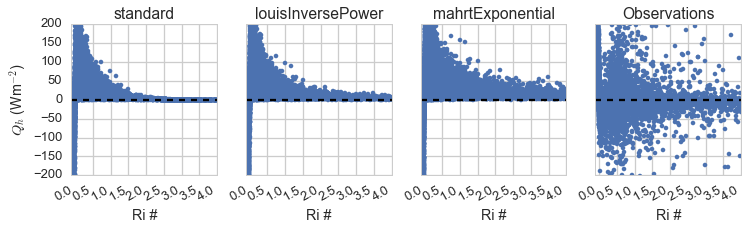

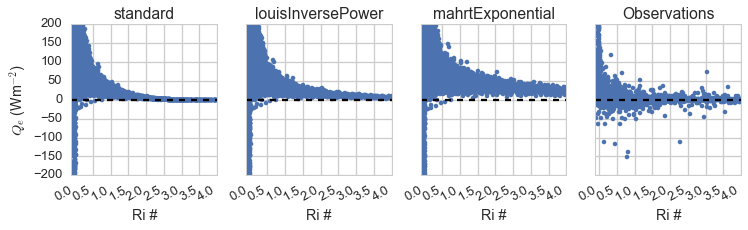

In [24]:
########
# Sensible
os.chdir(dirPrint)
fig,axes = plt.subplots(1,4,sharey=True,figsize=(12,3))
Qmax = 200
Qmin = -200
RiMax = 4.
RiMin = -0.1

for n,stab in enumerate(ixStability):
    ax = axes[n]
    ax.plot(Mtower.RiBulk[ind], sensible[stab],'.',label=stab)
    ax.plot([RiMin,RiMax],[0,0],'k--')
    ax.set_xlim(RiMin,RiMax)
    ax.set_ylim(Qmin,Qmax)
    ax.set_xlabel('Ri #')
    ax.set_title(stab)

ax = axes[0]
ax.set_ylabel('$Q_h$ (Wm$^{-2}$)')

ax = axes[-1]
ax.plot(Mtower.RiBulk[ind], \
        fluxObs.w_tc__10m_M[ind],\
        '.',label='Observations')
ax.plot([RiMin,RiMax],[0,0],'k--')
ax.set_ylim(Qmin,Qmax)
ax.set_xlim(RiMin,RiMax)
ax.set_xlabel('Ri #')
ax.set_title('Observations')

fig.autofmt_xdate()
# fig.savefig('ATMS547.OfflineTurb.SNQ_wind2ms.Sensible_Ri.pdf')

########
# Latent
os.chdir(dirPrint)
fig,axes = plt.subplots(1,4,sharey=True,figsize=(12,3))

for n,stab in enumerate(ixStability):
    ax = axes[n]
    ax.plot(Mtower.RiBulk[ind], latent[stab],'.',label=stab)
    ax.plot([RiMin,RiMax],[0,0],'k--')
    ax.set_xlim(RiMin,RiMax)
    ax.set_ylim(Qmin,Qmax)
    ax.set_xlabel('Ri #')
    ax.set_title(stab)

ax = axes[0]
ax.set_ylabel('$Q_e$ (Wm$^{-2}$)')

ax = axes[-1]
ax.plot(Mtower.RiBulk[ind], \
        fluxObs.w_h2o__10m_M[ind],\
        '.',label='Observations')
ax.plot([RiMin,RiMax],[0,0],'k--')
ax.set_ylim(Qmin,Qmax)
ax.set_xlim(RiMin,RiMax)
ax.set_xlabel('Ri #')
ax.set_title('Observations')

fig.autofmt_xdate()
# fig.savefig('ATMS547.OfflineTurb.SNQ_wind2ms.Latent_Ri.pdf')


ValueError: x and y must have same first dimension

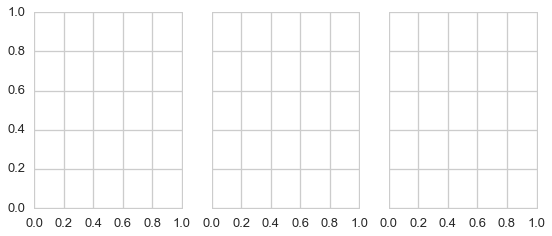

In [41]:
########
# Model Sensible vs Obs Sensible 
os.chdir(dirPrint)
fig,axes = plt.subplots(1,3,sharey=True,figsize=(9,3.5))
Qmax = 100
Qmin = -50

for n,stab in enumerate(ixStability):
    ax = axes[n]
    ax.plot(fluxObs.w_tc__10m_M[ind], sensible[stab],'.',label=stab)
    ax.plot([Qmin,Qmax],[Qmin,Qmax],'--k')
    ax.set_ylim(Qmin,Qmax)
    ax.set_xlim(Qmin,Qmax)
    ax.set_xlabel('Obs. $Q_h$ (Wm$^{-2}$)')
    ax.set_title(stab)

ax = axes[0]
ax.set_ylabel('Model $Q_h$ (Wm$^{-2}$)')

fig.autofmt_xdate()
# fig.savefig('ATMS547.OfflineTurb.SNQ_wind2ms.Sensible.pdf')

########
# Model Latent vs Obs Latent 
os.chdir(dirPrint)
fig,axes = plt.subplots(1,3,sharey=True,figsize=(9,3.5))
Qmax = 100
Qmin = -50

for n,stab in enumerate(ixStability):
    ax = axes[n]
    ax.plot(fluxObs.w_h2o__10m_M[ind], latent[stab],'.',label=stab)
    ax.plot([Qmin,Qmax],[Qmin,Qmax],'--k')
    ax.set_ylim(Qmin,Qmax)
    ax.set_xlim(Qmin,Qmax)
    ax.set_xlabel('Obs. $Q_e$ (Wm$^{-2}$)')
#     ax.set_title(stab)

ax = axes[0]
ax.set_ylabel('Model $Q_e$ (Wm$^{-2}$)')

fig.autofmt_xdate()
# fig.savefig('ATMS547.OfflineTurb.SNQ_wind2ms.Latent.pdf')


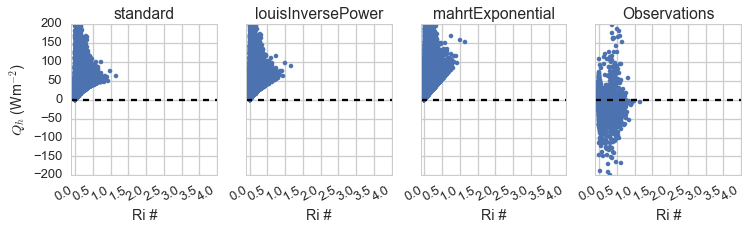

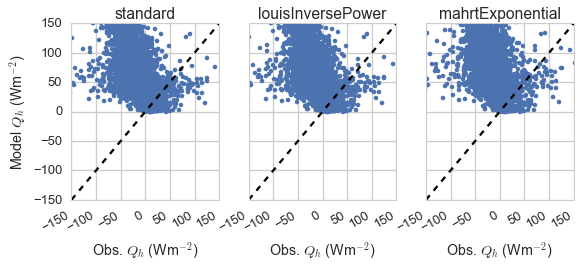

In [26]:
ind = np.nonzero( (Mtower.RiBulk > 0.).values & (Mtower.UBar_2m > 2.).values)
os.chdir(dirPrint)
########
# Sensible
fig,axes = plt.subplots(1,4,sharey=True,figsize=(12,3))
Qmax = 200
Qmin = -200
RiMax = 4.
RiMin = -0.1

for n,stab in enumerate(ixStability):
    ax = axes[n]
    ax.plot(Mtower.RiBulk[ind], sensible[stab][ind],'.',label=stab)
    ax.plot([RiMin,RiMax],[0,0],'k--')
    ax.set_xlim(RiMin,RiMax)
    ax.set_ylim(Qmin,Qmax)
    ax.set_xlabel('Ri #')
    ax.set_title(stab)

ax = axes[0]
ax.set_ylabel('$Q_h$ (Wm$^{-2}$)')

ax = axes[-1]
ax.plot(Mtower.RiBulk[ind], \
        fluxObs.w_tc__10m_M[ind],\
        '.',label='Observations')
ax.plot([RiMin,RiMax],[0,0],'k--')
ax.set_ylim(Qmin,Qmax)
ax.set_xlim(RiMin,RiMax)
ax.set_xlabel('Ri #')
ax.set_title('Observations')

fig.autofmt_xdate()

########
# Model Sensible vs Obs Sensible 
os.chdir(dirPrint)
fig,axes = plt.subplots(1,3,sharey=True,figsize=(9,3.5))
Qmax = 150
Qmin = -150

for n,stab in enumerate(ixStability):
    ax = axes[n]
    ax.plot(fluxObs.w_tc__10m_M[ind], sensible[stab][ind],'.',label=stab)
    ax.plot([Qmin,Qmax],[Qmin,Qmax],'--k')
    ax.set_ylim(Qmin,Qmax)
    ax.set_xlim(Qmin,Qmax)
    ax.set_xlabel('Obs. $Q_h$ (Wm$^{-2}$)')
    ax.set_title(stab)

ax = axes[0]
ax.set_ylabel('Model $Q_h$ (Wm$^{-2}$)')

fig.autofmt_xdate()
# fig.savefig('ATMS547.OfflineTurb.SNQ_wind2ms.Sensible.pdf')

########
# Model Latent vs Obs Latent 
# os.chdir(dirPrint)
# fig,axes = plt.subplots(1,3,sharey=True,figsize=(9,3.5))
# Qmax = 100
# Qmin = -50

# for n,stab in enumerate(ixStability):
#     ax = axes[n]
#     ax.plot(fluxObs.w_h2o__10m_M[ind], latent[stab][ind],'.',label=stab)
#     ax.plot([Qmin,Qmax],[Qmin,Qmax],'--k')
#     ax.set_ylim(Qmin,Qmax)
#     ax.set_xlim(Qmin,Qmax)
#     ax.set_xlabel('Obs. $Q_e$ (Wm$^{-2}$)')
# #     ax.set_title(stab)

# ax = axes[0]
# ax.set_ylabel('Model $Q_e$ (Wm$^{-2}$)')

# fig.autofmt_xdate()
# # fig.savefig('ATMS547.OfflineTurb.SNQ_wind2ms.Latent.pdf')


# SUMMA Turbulence
This should become a package soon....

In [19]:
def turbFluxes(
        # input: model control
        ixDerivMethod,                  # choice of method used to compute derivative (analytical or numerical)
        ixStability,                    # method for calculating stability
        # input: above-canopy forcing data
        airTemp,                        # air temperature at some height above the surface (K)
        airPres,                        # air pressure of the air above the vegetation canopy (Pa)
        VPair,                          # vapor pressure of the air above the vegetation canopy (Pa)
        windspd,                        # wind speed above the canopy (m s-1)    
        # input: canopy and ground temperature
        groundTemp,                     # ground temperature (K)
        # input: diagnostic variables
        soilRelHumidity,                # relative humidity in the soil pores [0-1]
        mHeight,
        snowDepth
        ):
# --------------------------------------------------------------------------------------------------------------------
    if np.isnan(airTemp) or np.isnan(airPres) or np.isnan(VPair) or np.isnan(groundTemp):
#         print('Input data includes nan value. Exiting and returning nans...')
        return (
                np.nan,                # ground conductance for sensible heat (m s-1)
                np.nan,                # ground conductance for latent heat (m s-1)
                # output: fluxes from non-vegetated surfaces
                np.nan,                      # sensible heat flux from ground surface (W m-2)
                np.nan,                      # latent heat flux from ground surface (W m-2)
                np.nan,                     # net turbulent heat fluxes at the ground surface (W m-2)
                # output: energy flux derivatives
                np.nan,           # derivative in net turbulent fluxes w.r.t. ground temperature (W m-2 K-1)
                )
    
    
    ########
    # Local variables
    evapSmooth=1.                                  # smoothing parameter for latent heat (W m-2)
    volHeatCapacityAir = iden_air*Cp_air           # volumetric heat capacity of air (J m-3)
    latentHeatConstant = iden_air*w_ratio/airPres  # latent heat constant for (kg m-3 Pa-1)
    # soilResistance is an unclear term for snow -- there is no resistance from snow: Sellers (1992)
    # scalarSoilResistance = scalarGroundSnowFraction*1. + (1. - groundSnowFraction)*EXP(8.25 - 4.225*soilEvapFactor)  
    soilResistance = 1.
    
    ########
    # saturation vapor pressure at the temperature of the ground (Pa)
    (satVP_GroundTemp,empty) = satVapPress(groundTemp - Tfreeze)
    
    #######
    # Latent Heat - Vaporization or sublimation. 
    # NOTE: The physics implied here is wrong. Point to bring up with Martyn/Bart
    if scalarGroundSnowFraction > 0. and groundTemp < Tfreeze:
        latHeatSubVapGround = LH_sub  # sublimation from snow
    # case when the ground is snow-free
    # evaporation of water in the soil pores, this occurs even if frozen because of super-cooled water
    elif scalarGroundSnowFraction == 0.:
        latHeatSubVapGround = LH_vap
    else:
        latHeatSubVapGround = LH_sub
    
    ########
    # compute resistances
    derivDesired = 'analytical' in ixDerivMethod or 'numerical' in ixDerivMethod
    resistOut = aeroResist(
                    derivDesired,               # flag to indicate if analytical derivatives are desired
                    ixStability,                # choice of stability function
                    # input: above-canopy forcing data
                    mHeight,                    # measurement height (m)
                    airTemp,                    # air temperature at some height above the surface (K)
                    windspd,                    # wind speed at some height above the surface (m s-1)
                    # input: temperature (canopy, ground, canopy air space)
                    groundTemp,                 # ground temperature (K)
                    # input: diagnostic variables
                    snowDepth,                  # snow depth (m)
                    # input: parameters
                    z0Ground,                   # surface roughness length (below canopy/non-vegetated [snow]) (m)
                    critRichNumber,             # critical value for the bulk Richardson number (-)
                    Louis79_bparam,             # parameter in Louis (1979) stability function
                    Mahrt87_eScale              # exponential scaling factor in the Mahrt (1987) stability function
                    )
    
    # Unpack resistances
    (RiBulkGround,                  # bulk Richardson number for the ground surface (-)
    groundStabilityCorrection,      # stability correction for the ground surface (-)
    groundResistance,               # below canopy aerodynamic resistance (s m-1)
    dGroundResistance_dTGround      # derivative in ground resistance w.r.t. ground temperature (s m-1 K-1)
    ) = resistOut
    
    ########
    # compute conductances, and derivatives...
    # NOTE: soilResistance accounts for fractional snow, and =0 when snow cover is 100%
    groundConductanceLH = 1./(groundResistance + soilResistance)
    groundConductanceSH = 1./groundResistance
    
    ########
    # compute sensible and latent heat fluxes, and derivatives...
    # (positive downwards)
    senHeatGround      = -volHeatCapacityAir*groundConductanceSH*(groundTemp - airTemp)
    latHeatGround      = -latHeatSubVapGround*latentHeatConstant*groundConductanceLH * \
                          (satVP_GroundTemp*soilRelHumidity - VPair)
    
    
    # compute derivatives
    if ixDerivMethod == 'analytical':
        # compute derivatives for the ground fluxes w.r.t. ground temperature
        # d(ground sensible heat flux)/d(ground temp)
        dSenHeatGround_dTGround =   (-volHeatCapacityAir*dGroundCondSH_dGroundTemp)*(groundTemp - airTemp) + \
                                    (-volHeatCapacityAir*groundConductanceSH)
        # d(ground latent heat flux)/d(ground temp)
        dLatHeatGround_dTGround =   (-latHeatSubVapGround*latentHeatConstant*dGroundCondLH_dGroundTemp) * \
                                    (satVP_GroundTemp*soilRelHumidity - VPair) + \
                                    (-latHeatSubVapGround*latentHeatConstant*groundConductanceLH) * \
                                    dSVPGround_dGroundTemp*soilRelHumidity

    ########
    # net turbulent flux at the ground surface (W m-2)
    turbFluxGround = senHeatGround + latHeatGround

    # compute derivatives
    if ixDerivMethod == 'analytical':
        # (energy derivatives)
        # derivative in net ground turbulent fluxes w.r.t. ground temperature (W m-2 K-1)
        dTurbFluxGround_dTGround = dSenHeatGround_dTGround + dLatHeatGround_dTGround
    else: # (just make sure we return something)
        # (energy derivatives)
        dTurbFluxGround_dTGround = -9999

    return (
        groundConductanceSH,                # ground conductance for sensible heat (m s-1)
        groundConductanceLH,                # ground conductance for latent heat (m s-1)
        # output: fluxes from non-vegetated surfaces
        senHeatGround,                      # sensible heat flux from ground surface (W m-2)
        latHeatGround,                      # latent heat flux from ground surface (W m-2)
        turbFluxGround,                     # net turbulent heat fluxes at the ground surface (W m-2)
        # output: energy flux derivatives
        dTurbFluxGround_dTGround,           # derivative in net turbulent fluxes w.r.t. ground temperature (W m-2 K-1)
        )
###########################################################################################################

def aeroResist( derivDesired,               # flag to indicate if analytical derivatives are desired
                ixStability,                # choice of stability function
                # input: above-canopy forcing data
                mHeight,                    # measurement height (m)
                airTemp,                    # air temperature at some height above the surface (K)
                windspd,                    # wind speed at some height above the surface (m s-1)
                # input: temperature (canopy, ground, canopy air space)
                groundTemp,                 # ground temperature (K)
                # input: diagnostic variables
                snowDepth,                  # snow depth (m)
                # input: parameters
                z0Ground,                   # surface roughness length (below canopy/non-vegetated [snow]) (m)
                critRichNumber,             # critical value for the bulk Richardson number (-)
                Louis79_bparam,             # parameter in Louis (1979) stability function
                Mahrt87_eScale              # exponential scaling factor in the Mahrt (1987) stability function
                ):
# -------------------------------------------------------------------------------------------------------
# compute aerodynamic resistances
# Refs: Choudhury and Monteith (4-layer model for heat budget of homogenous surfaces; QJRMS, 1988)
#       Niu and Yang (Canopy effects on snow processes; JGR, 2004)
#       Mahat et al. (Below-canopy turbulence in a snowmelt model, WRR, 2012)
# -------------------------------------------------------------------------------------------------------

    # local variables: general
    C_r = 0.3                 # roughness element drag coefficient (-) from Raupach (BLM, 1994)
    C_s = 0.00                # substrate surface drag coefficient (-) from Raupach (BLM, 1994)
    approxDragCoef_max = 0.   # maximum value of the approximate drag coefficient (-) from Raupach (BLM, 1994)
    vkc = 0.4                 # von Karman constant (-)

    ########
    # compute resistance for the case without a canopy (bare ground, or canopy completely buried with snow)

    # check that measurement height above the ground surface is above the roughness length
    if mHeight < snowDepth+z0Ground:
        error('measurement height < snow depth + roughness length')

    # turbulent transfer coefficient under conditions of neutral stability (-)
    groundExNeut = (vkc**2.) / ( np.log((mHeight - snowDepth)/z0Ground)**2.) 
    # compute the resistance between the surface and canopy air UNDER NEUTRAL CONDITIONS (s m-1)
    groundResistanceNeutral = 1. / (groundExNeut*windspd)

    # define height above the snow surface
    heightAboveGround  = mHeight - snowDepth

    # check that measurement height above the ground surface is above the roughness length
    if heightAboveGround < z0Ground:
        print(\
                'z0Ground = %d \n' \
                'mHeight  = %d \n' \
                'snowDepth = %d \n' \
                'heightAboveGround = %d \n' \
                , (z0Ground,mHeight,snowDepth,heightAboveGround))
        error('height above ground < roughness length [likely due to snow accumulation]')

    # compute ground stability correction
    aStabilityOut = aStability(
                  # input
                  derivDesired,                                 # logical flag to compute analytical derivatives
                  ixStability,                                  # choice of stability function
                  # input: forcing data, diagnostic and state variables
                  heightAboveGround,                            # measurement height above the ground surface (m)
                  airTemp,                                      # temperature above the ground surface (K)
                  groundTemp,                                   # trial value of surface temperature (K)
                  windspd,                                      # wind speed above the ground surface (m s-1)
                  # input: stability parameters
                  critRichNumber,                               # critical value for the bulk Richardson number (-)
                  Louis79_bparam,                               # parameter in Louis (1979) stability function
                  Mahrt87_eScale,                               # exponential scaling factor in Mahrt stability
                  )

    # Unpack
    (RiBulkGround,                               # bulk Richardson number (-)
    groundStabilityCorrection,                   # stability correction for turbulent heat fluxes (-)
    dGroundStabilityCorrection_dRich,            # derivative in stab. corr. w.r.t. Ri for the ground surface (-)
    dGroundStabilityCorrection_dAirTemp,         # derivative in stab. corr. w.r.t. air temperature (K-1)
    dGroundStabilityCorrection_dSfcTemp)  = aStabilityOut # derivative in stab. corr. w.r.t. surface temperature (K-1)

    # compute the ground resistance (after stability corrections)
    groundResistance = groundResistanceNeutral/groundStabilityCorrection
    if groundResistance < 0.:
        error('ground resistance < 0 [no vegetation]')

    # if analytical derivatives are desired
    if derivDesired: 

        # compute derivatives for ground resistance
        dGroundResistance_dTGround = -dGroundStabilityCorrection_dSfcTemp/ \
                                        (windspd*groundExNeut*groundStabilityCorrection**2.)
    else:
        dGroundResistance_dTGround = -9999

    return  (RiBulkGround,              # bulk Richardson number for the ground surface (-)
        groundStabilityCorrection,      # stability correction for the ground surface (-)
        groundResistance,               # below canopy aerodynamic resistance (s m-1)
        dGroundResistance_dTGround)     # derivative in ground resistance w.r.t. ground temperature (s m-1 K-1)

###########################################################################################################

def aStability(# input: control
               computeDerivative,              # logical flag to compute analytical derivatives
               ixStability,                    # choice of stability function
               # input: forcing data, diagnostic and state variables
               mHeight,                        # measurement height (m)
               airTemp,                        # air temperature (K)
               sfcTemp,                        # surface temperature (K)
               windspd,                        # wind speed (m s-1)
               # input: stability parameters
               critRichNumber,                 # critical value for the bulk Richardson number (-)
               Louis79_bparam,                 # parameter in Louis (1979) stability function
               Mahrt87_eScale,                 # exponential scaling factor in the Mahrt (1987) stability function
               ):
# --------------------------------------------------------------------------------------------------------------------
    #### "standard" stability correction, a la Anderson 1976
    def standardStability():    
        # compute surface-atmosphere exchange coefficient (-)
        if RiBulk <  critRichNumber:
            stabilityCorrection = (1. - 5.*RiBulk)**2.
        elif RiBulk >= critRichNumber:
            # stabilityCorrection = epsilon(stabilityCorrection)
            stabilityCorrection = machineEpsilon
        else: 
            stabilityCorrection = machineEpsilon
            
        # compute derivative in surface-atmosphere exchange coefficient w.r.t. temperature (K-1)
        if computeDerivative:
            if RiBulk <  critRichNumber:
                dStabilityCorrection_dRich = (-5.) * 2.*(1. - 5.*RiBulk)
            if RiBulk >= critRichNumber:
                dStabilityCorrection_dRich = 0.
        else:
            dStabilityCorrection_dRich = -9999
        return stabilityCorrection,dStabilityCorrection_dRich

    #### Louis 1979
    def louisInversePower():
        # scale the "b" parameter for stable conditions
        bprime = Louis79_bparam/2.
        # compute surface-atmosphere exchange coefficient (-)
        stabilityCorrection = 1. / ( (1. + bprime*RiBulk)**2. )
        if stabilityCorrection < machineEpsilon:
            stabilityCorrection = machineEpsilon
        # compute derivative in surface-atmosphere exchange coefficient w.r.t. temperature (K-1)
        if computeDerivative:
            dStabilityCorrection_dRich = bprime * (-2.)*(1. + bprime*RiBulk)**(-3.)
        else:
            dStabilityCorrection_dRich = -9999
        return stabilityCorrection,dStabilityCorrection_dRich

    #### Mahrt 1987
    def mahrtExponential():
        # compute surface-atmosphere exchange coefficient (-)
        stabilityCorrection = np.exp(-Mahrt87_eScale * RiBulk)
        if stabilityCorrection < machineEpsilon:
            stabilityCorrection = machineEpsilon
        # compute derivative in surface-atmosphere exchange coefficient w.r.t. temperature (K-1)
        if computeDerivative:
            dStabilityCorrection_dRich = (-Mahrt87_eScale) * np.exp(-Mahrt87_eScale * RiBulk)
        else:
            dStabilityCorrection_dRich = -9999
        return stabilityCorrection,dStabilityCorrection_dRich   

    #### Stability Error Message
    def stabErrMess():
        error('Did not recognize stability choice: '+ixStability+'\n',
             'Valid stability options: standard, louisInversePower, mahrtExponential')
# --------------------------------------------------------------------------------------------------------------------
    
    # compute the bulk Richardson number (-)
    bulkRichardsonOut = bulkRichardson(# input
                                        airTemp,                        # air temperature (K)
                                        sfcTemp,                        # surface temperature (K)
                                        windspd,                        # wind speed (m s-1)
                                        mHeight,                        # measurement height (m)
                                        computeDerivative,              # flag to compute the derivative
                                        )

    # output
    (RiBulk,                             # bulk Richardson number (-)
    dRiBulk_dAirTemp,                    # derivative in the bulk Richardson number w.r.t. air temperature (K-1)
    dRiBulk_dSfcTemp) = bulkRichardsonOut # derivative in the bulk Richardson number w.r.t. surface temperature (K-1)
    
    # set derivative to one if not computing it
    if not computeDerivative:
        dStabilityCorrection_dRich    = 1.
        dStabilityCorrection_dAirTemp = 1.
        dStabilityCorrection_dSfcTemp = 1.

    #########
    # process unstable cases
    if RiBulk<0.:
        # compute surface-atmosphere exchange coefficient (-)
        stabilityCorrection = (1. - 16.*RiBulk)**0.5
        # compute derivative in surface-atmosphere exchange coefficient w.r.t. temperature (K-1)
        if computeDerivative:
            dStabilityCorrection_dRich    = (-16.) * 0.5 *(1. - 16.*RiBulk)**(-0.5)
            dStabilityCorrection_dAirTemp = dRiBulk_dAirTemp * dStabilityCorrection_dRich
            dStabilityCorrection_dSfcTemp = dRiBulk_dSfcTemp * dStabilityCorrection_dRich
        
    ######## 
    # process stable cases
    # Use a dictionary of functions to select stability function
    else:
        stabilityCase = {
            'standard': standardStability,
            'louisInversePower': louisInversePower,
            'mahrtExponential': mahrtExponential,
        }

        # Get the function from switcher dictionary
        func = stabilityCase.get(ixStability, stabErrMess)

        # Execute the function
        stabilityCorrection,dStabilityCorrection_dRich = func()

        # Derivative of stable cases
        if computeDerivative:
            dStabilityCorrection_dAirTemp = dRiBulk_dAirTemp * dStabilityCorrection_dRich
            dStabilityCorrection_dSfcTemp = dRiBulk_dSfcTemp * dStabilityCorrection_dRich
    
    
    return  (RiBulk,                                # bulk Richardson number (-)
            stabilityCorrection,                    # stability correction for turbulent heat fluxes (-)
            dStabilityCorrection_dRich,             # derivative in stab. corr. w.r.t. Ri for the ground surface (-)
            dStabilityCorrection_dAirTemp,          # derivative in stab. corr. w.r.t. air temperature (K-1)
            dStabilityCorrection_dSfcTemp)          # derivative in stab. corr. w.r.t. sfc temperature (K-1)



In [20]:
ave_slp      =  101325.0             # mean sea level pressure              (Pa)
vkc          =       0.4             # von Karman constant                  (-)
satvpfrz     =     610.8             # sat vapour pressure at 273.16K       (Pa)
w_ratio      =       0.622           # molecular ratio water to dry air     (-)
R_da         =     287.053           # gas constant for dry air             (Pa K-1 m3 kg-1; J kg-1 K-1)
R_wv         =     461.285           # gas constant for water vapor         (Pa K-1 m3 kg-1; J kg-1 K-1)
gravity      =       9.80616         # acceleration of gravity              (m s-2)
Cp_air       =    1005.              # specific heat of air                 (J kg-1 K-1)
Cp_ice       =    2114.              # specific heat of ice                 (J kg-1 K-1)
Cp_soil      =     850.              # specific heat of soil                (J kg-1 K-1)
Cp_water     =    4181.              # specific heat of liquid water        (J kg-1 K-1)
Tfreeze      =     273.16            # temperature at freezing              (K)
TriplPt      =     273.16            # triple point of water                (K)
LH_fus       =  333700.0             # latent heat of fusion                (J kg-1)
LH_vap       = 2501000.0             # latent heat of vaporization          (J kg-1)
LH_sub       = 2834700.0             # latent heat of sublimation           (J kg-1)
lambda_air   =       0.026           # thermal conductivity of air          (W m-1 K-1)
lambda_ice   =       2.50            # thermal conductivity of ice          (W m-1 K-1)
lambda_water =       0.60            # thermal conductivity of liquid water (W m-1 K-1)
iden_air     =       1.293           # intrinsic density of air             (kg m-3)
iden_ice     =     917.0             # intrinsic density of ice             (kg m-3)
iden_water   =    1000.0             # intrinsic density of liquid water    (kg m-3)
secprday     =   86400.              # number of seconds in a day
secprhour    =    3600.              # number of seconds in an hour
secprmin     =      60.              # number of seconds in a minute

## Conversion Functions

In [21]:
###########################################################################################################

def vapPress(q,p):
# Input
# q :        specific humidity (g g-1)
# p :        pressure (Pa)
# Output
# vapPress : vapor pressure (Pa)

    w_ratio = 0.622                     # molecular weight ratio of water to dry air (-)
    w = q / (1. - q)                    # mixing ratio (-)
    vapPress = (w/(w + w_ratio))*p      # vapor pressure (Pa)

    return vapPress

def satVapPress(TC):
# Uses Teten's formula to compute saturated vapor pressure (Pa)
# NOTE: temperature units are degC !!!!
# input
# TC : temperature (C)
# output
# SVP      : saturation vapor pressure (Pa)
# dSVP_dT  : d(SVP)/dT

    X1 = 17.27
    X2 = 237.30
    dx = 1.*10**(-8)                                        # finite difference increment
    SATVPFRZ = 610.8                                        # Saturation water vapour pressure at 273.16K (Pa)
    SVP     = SATVPFRZ * np.exp( (X1*TC)/(X2 + TC) )        # Saturated Vapour Press (Pa)
    dSVP_dT = SVP * (X1/(X2 + TC) - X1*TC/(X2 + TC)**2.)
    
    return SVP,dSVP_dT